## Executive Summary:

**Project Goal:** This project uses a dataset of credit card fraud. The goal is to properly identify fraud using an anomaly detection algorithm. It is also important to note that this was manually coded as opposed to using a standard library like scikit-learn. The intention is to demonstrate the bath behind the algorithm.

**Methodology:** The primary method used in this project is Gaussian estimation. We split the data into three datasets: a training set (which includes no anomalies), a validation set (which includes normal and anomalous data), and a test set (which also includes normal and anomalous data). We first train the model on the training set, find the threshold with the validation set, and test the algorithm using the test set. 

**Results:** The final model has an accuracy of 99.42% compared to a baseline accuracy of 99.57%. Though this falls below the baseline, it still demonstrates a successful model. I will analyze the results more in the conclusion.

**Dataset:** The data used in this project is open-sourced from Kaggle. You can find the original dataset [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). 

## Step 0: Import Dependencies and Data

In [ ]:
%pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('data/creditcard.csv')

## Step 1: Data Exploration

**Note about the data:** The features of this dataset are mostly unlabeled. Due to privacy rights, the originators of the data were unable to label the entire set. We are still able to run it through all of the necessary algorithms to make our predictions. The limitation is that we just can't get an intuition of all of the features. Either way, let's see what we do have.

In [4]:
# Verify the data imported correctly

print(df.head(5))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [5]:
# Normal vs. Anomalous Examples

count_class = df['Class'].value_counts()
print(count_class)

Class
0    284315
1       492
Name: count, dtype: int64


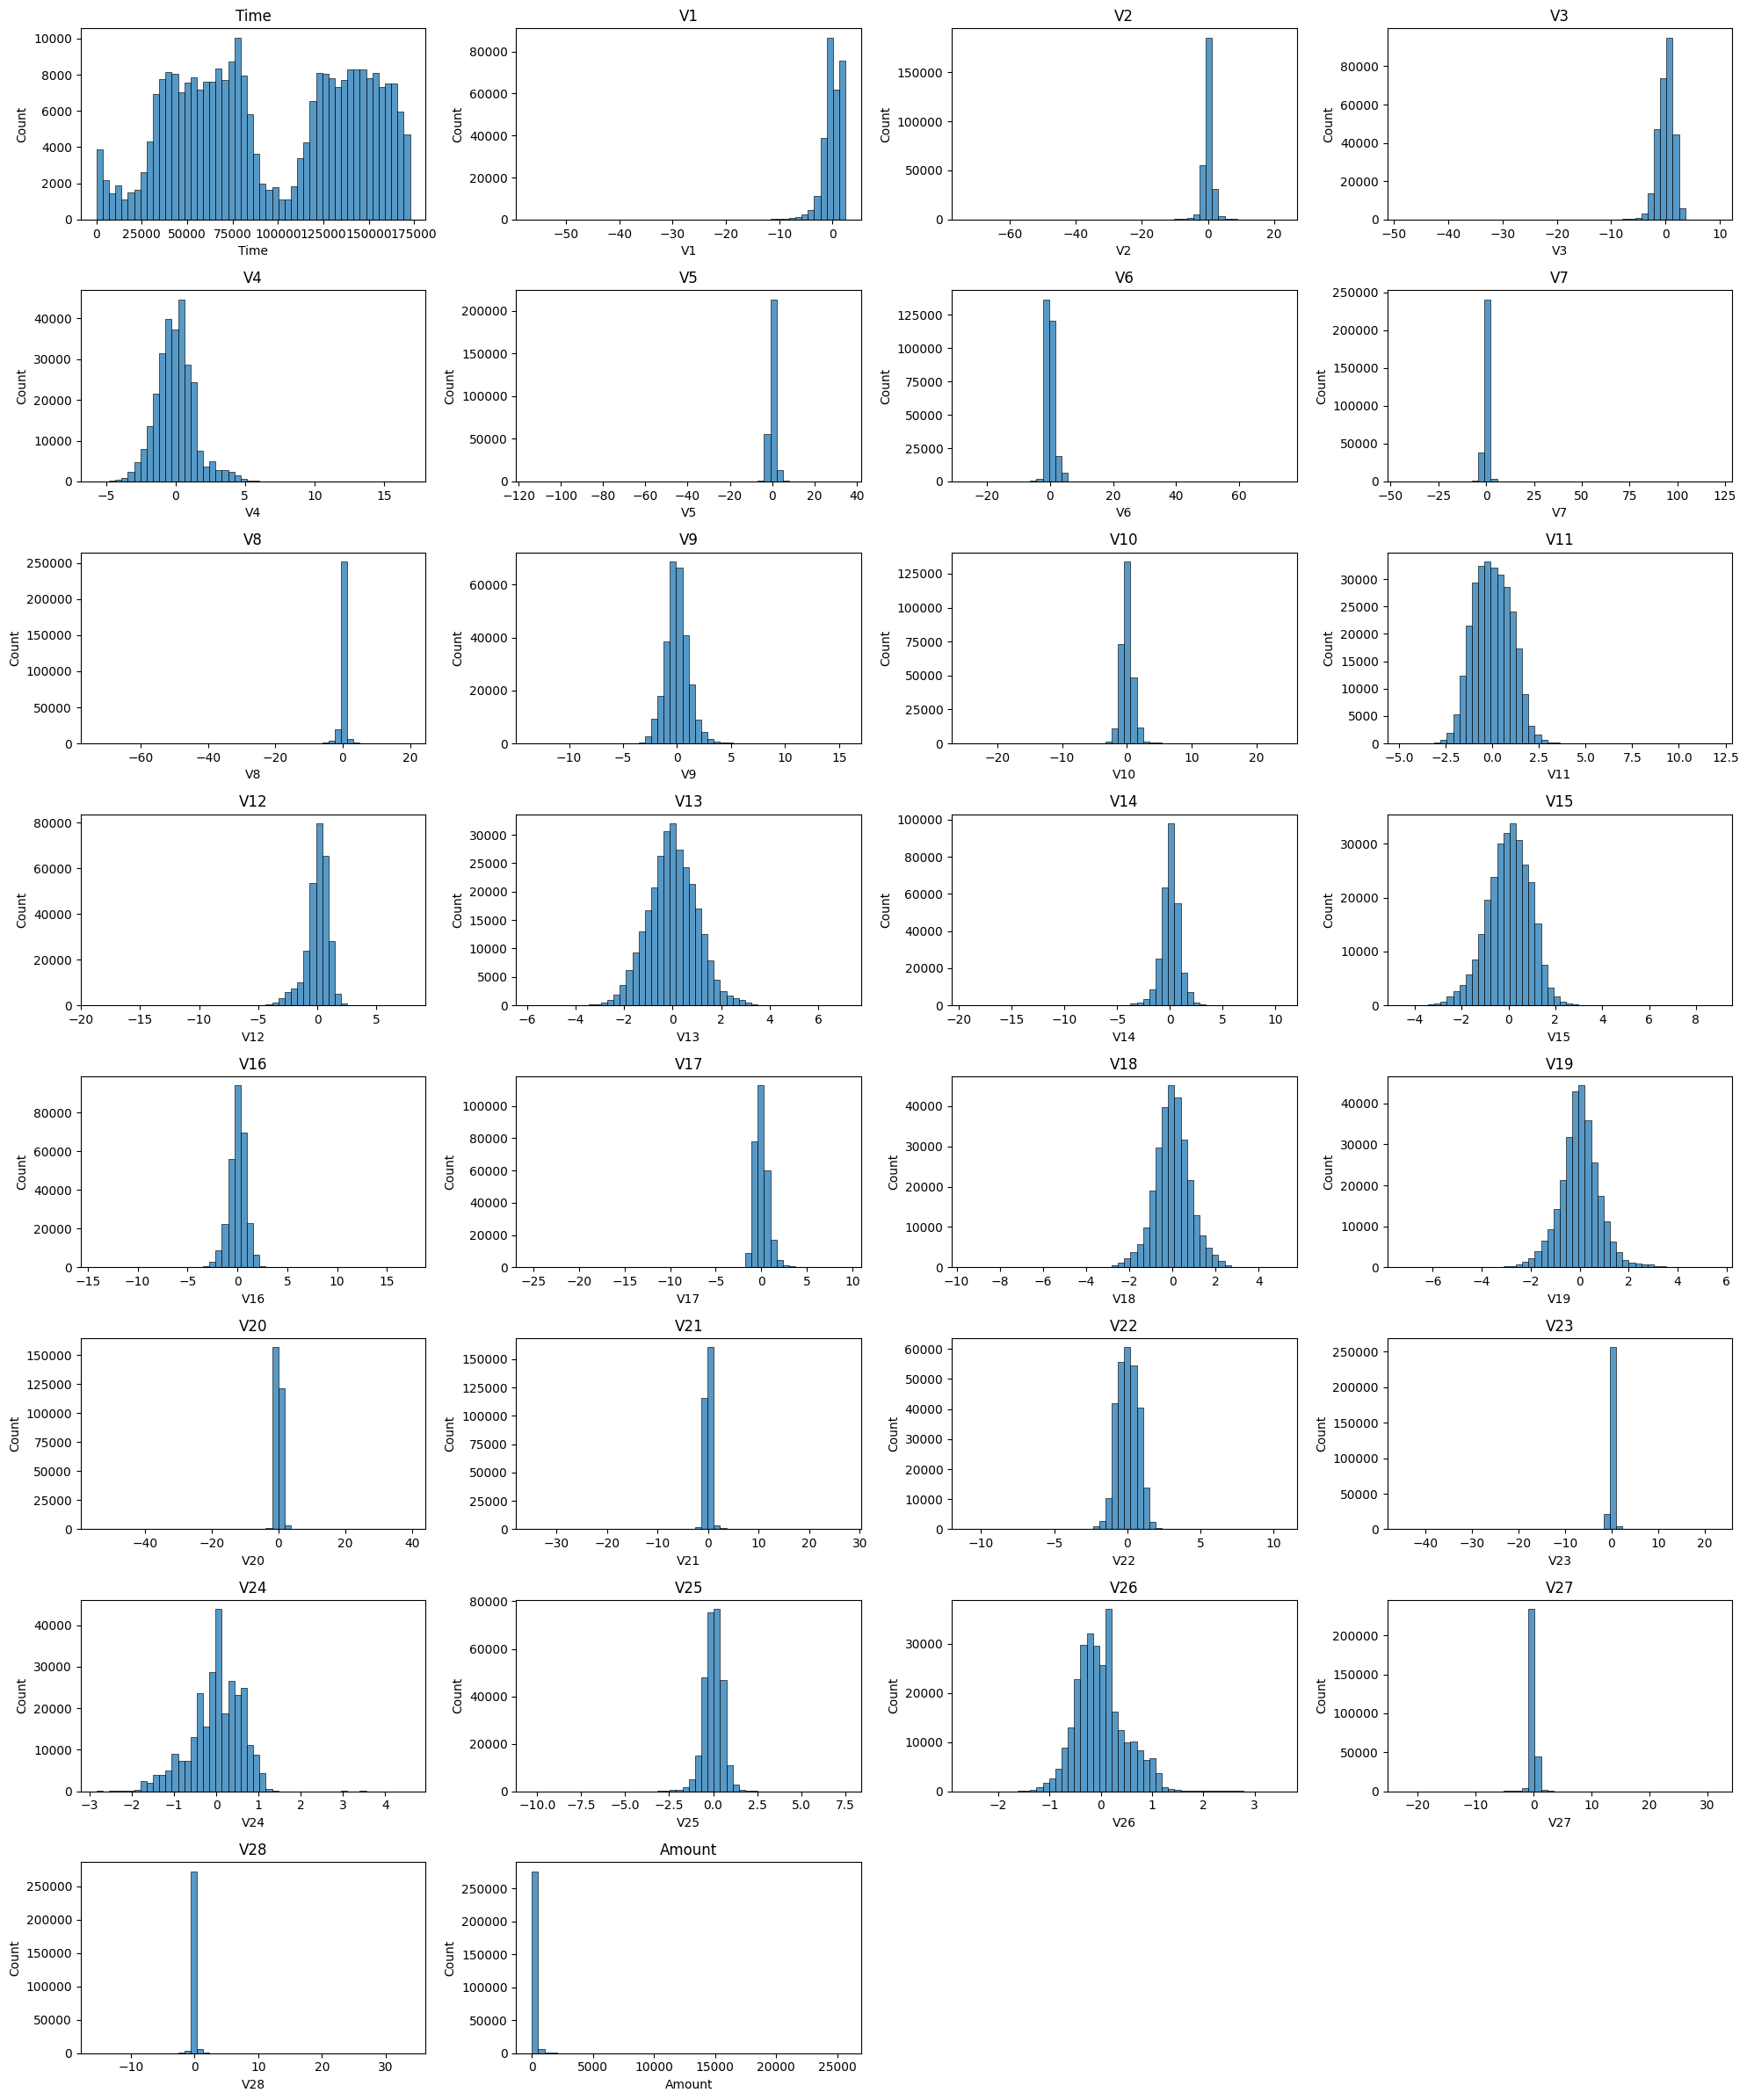

In [6]:
# Plot a histogram for each feature to get a sense of Gaussian distribution

# Drop the 'Class' column for plotting features. Currently not needed
features = df.drop(['Class'], axis=1).columns

n_cols = 4
n_rows = (len(features) + n_cols -1) // n_cols
plt.figure(figsize=(20, n_rows * 3))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1) 
    sns.histplot(df[feature], bins=50)
    plt.title(feature)

plt.tight_layout()
plt.show()

More or less, the features are Gaussian. Let's take a closer look at the Time and Amount labeled features.

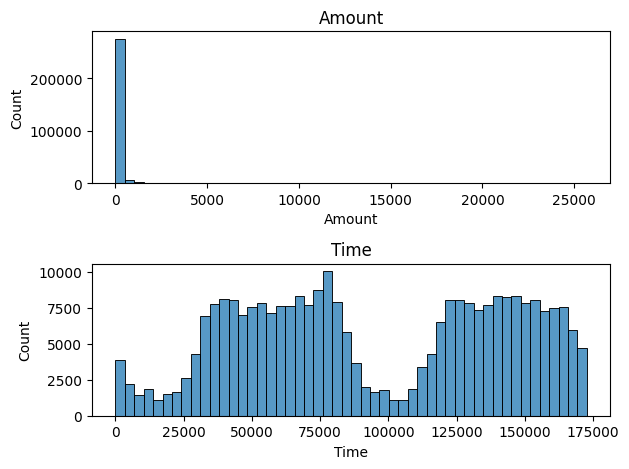

In [7]:
features = ['Amount', 'Time']

n_cols = 1
n_rows = 2

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1) 
    sns.histplot(df[feature], bins=50)
    plt.title(feature)

plt.tight_layout()
plt.show()

**Amount Feature:** Looking at the graph, the "Amount" feature is extremely skewed to smaller transaction amounts with a long tail. In order to estimate the Gaussian distribution later, we need to transform the feature. To do that, we will perform Log Transformation.

In [8]:
df['Log_Amount'] = np.log(df['Amount'] + 1)
print("Success")

Success


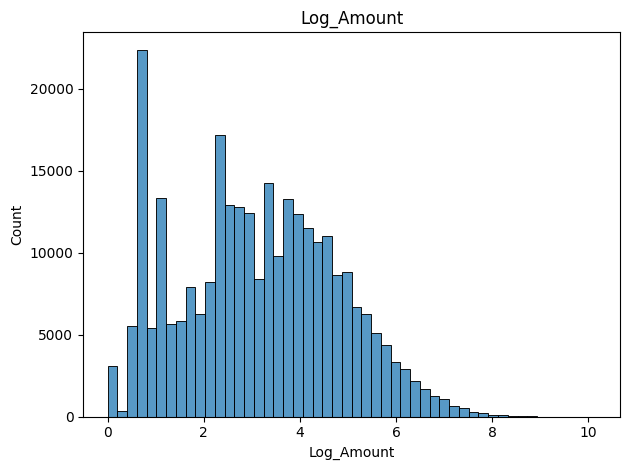

In [9]:
features = ['Log_Amount']

n_cols = 1
n_rows = 1

for feature in features:
    plt.subplot(n_rows, n_cols, 1) 
    sns.histplot(df[feature], bins=50)
    plt.title(feature)

plt.tight_layout()
plt.show()

This looks much better. As a note, I tried different log amounts. This provided the best distribution that I could observe. There still is a slight skew towards the left but it's much better than before.

**Time Feature:** Looking at the data, the time is in seconds over a 48 hour period. This is not intuitive for the model. So, I transformed this feature into an "Hour" feature as follows:



In [10]:
# Seconds to Hours

df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600) % 24)

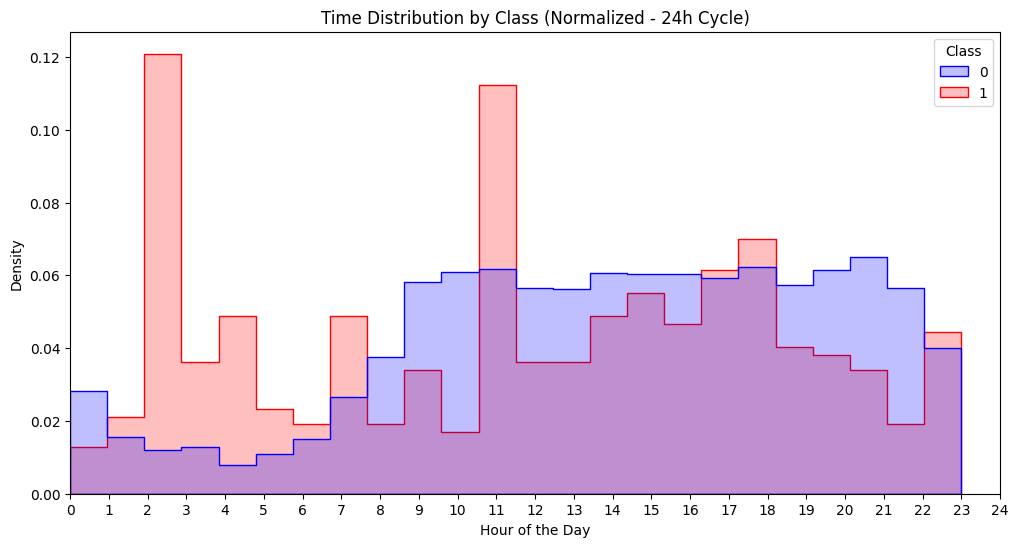

In [11]:
# Plotting new Hour feature. Density of Anomalous vs Normal activities

plt.figure(figsize=(12, 6))

sns.histplot(
    data=df, 
    x='Hour', 
    hue='Class', 
    stat='density',    
    common_norm=False,   
    bins=24,             # 1 bin per hour
    palette={0: "blue", 1: "red"},
    element="step"
)

plt.title('Time Distribution by Class (Normalized - 24h Cycle)')
plt.xlabel('Hour of the Day')
plt.ylabel('Density')
plt.xlim(0, 24)
plt.xticks(range(0, 25))

plt.show()

**Note:** When viewing this histogram of the fraudulent vs normal activities, it is clear that fraud happens at all hours of the day. However, there is a slight trend to have more fraudulent activities occur in the "wee hours" of a day. I thought this might be a good feature.

Accordingly, I trained and tested the model on the original data, and with the "Hour" feature. Using this feature did not improve model performance compared to the baseline, so I excluded it from the final mode.

## Step 2: Data Preprocessing

First, let's make sure we only keep the features we want. We will remove Hour and Time as noted above. We can also remove Amount because we have the new Log_Amount feature.

In [12]:
df = df.drop(['Time','Amount', 'Hour'], axis = 1)

In order to properly train our model, we need to split our data into three different sets:

**Training Set:**
This will include 60% of the normal data, i.e. non-anomalous.
This data will be used to train the initial model.

**Validation Set**
This will include 20% of the normal data, and 50% of the anomalous data.
This data will be used to determine the best epsilon for p(x).

**Test Set**
This will include 20% of the normal data, and 50% of the anomalous data.
This data will be used as a final test.

For this step, we will use the train_test_split function from scikit-learn, but first we need to separate normal vs. anomalous examples

In [13]:
df_normal = df[df['Class'] == 0]
df_anomaly = df[df['Class'] == 1]

In [14]:
# Quick count of normal vs anomalous features. Not necessary to run

print(len(df_normal))
print(len(df_anomaly))

284315
492


In [15]:
# Train set keeps 60% of normal activities
df_train, df_ = train_test_split(df_normal, test_size=0.40, random_state=1)

# Validation and Test sets each keep 20% of normal activities
df_val, df_test = train_test_split(df_, test_size=0.50, random_state=1)

# Validation and Test sets each keep 50% of anomalous activities
df_val_anomaly, df_test_anomaly = train_test_split(df_anomaly, test_size=0.50, random_state=1)

In [16]:
# Combine normal + anomalies
# Define y_cv and y_test
# Drop the class columns

# TRAIN
df_train = df_train.drop(['Class'], axis=1)

# VALIDATION
df_val = pd.concat([df_val, df_val_anomaly])
df_y_val = df_val['Class']
df_val = df_val.drop(['Class'], axis=1)

# TEST
df_test = pd.concat([df_test, df_test_anomaly])
df_y_test = df_test['Class']
df_test = df_test.drop(['Class'], axis=1)

In [17]:
# Convert to Numpy

X_train = df_train.to_numpy()
X_val = df_val.to_numpy()
y_val = df_y_val.to_numpy()
X_test = df_test.to_numpy()
y_test = df_y_test.to_numpy()

## Step 3. Model Training and Validation

### 3a: Gaussian Estimation

Our data is now ready to train, validate, and test. For this project, I am going to use Gaussian Estimation.

**Note on Methodology:** At this point, I could use the scikit-learn library to perform anomaly detection. However, this project is to highlight my understanding of first principles and manually implement the Gaussian estimation. So, let's get into the code:

In [18]:
def estimate_gaussian(X):

    """
    Arguments:
      X (ndarray): training data X (m, n)

    Returns:
      mu (ndarray): mean of n features
      variance (ndarray): variance of n features
    """
    
    m, n = X.shape

    mu = np.mean(X, axis = 0)

    squared_diff_sum = np.sum((X - mu) ** 2, axis = 0)
    
    variance = (1 / m) * squared_diff_sum

    return mu, variance

We are now able to train the model using X_train.

In [19]:
mu, variance = estimate_gaussian(X_train)

print(f"Mu is: {mu}")
print(f"Variance is: {variance}")

Mu is: [ 7.98738080e-03 -6.17349428e-03  8.42795587e-03 -8.97006836e-03
  8.09726706e-03  2.03912096e-03  9.28112641e-03 -6.42759036e-04
  3.91570062e-03  1.13765483e-02 -1.01983724e-02  1.34021267e-02
  7.89214964e-04  9.81614769e-03 -8.54902105e-06  6.85389613e-03
  1.17795810e-02  4.70298063e-03 -5.72898697e-04 -9.14094957e-05
 -1.60432535e-03 -9.95003480e-04  3.87807867e-04  1.51155391e-03
  2.36568188e-05 -4.19915563e-04 -1.25114388e-03 -4.13797641e-04
  3.15165455e+00]
Variance is: [3.72407548 2.68263482 2.14168774 1.94811291 1.85889222 1.77338699
 1.40947518 1.3429516  1.18713186 1.09596709 1.00093479 0.88801663
 0.98700423 0.80443628 0.83845584 0.71169661 0.55504466 0.67915437
 0.65740259 0.60414466 0.50770959 0.52367183 0.38164549 0.36631544
 0.26915    0.23224409 0.16420829 0.10380607 2.73286013]


### 3b: Model Definition (Probability Density Function)

Now, from the learned mu and variance parameters, we have to calculate the likelihood a new example is an anomaly or not. We will start by calculating probability density $p(x)$.

In [20]:
def probability_density(X, mu, variance):

    """
    Arguments:
      X (ndarray): Input data of shape (m, n) containing m examples and n features.
      mu (ndarray): Mean parameter of shape (n,) derived from the training set.
      variance (ndarray): Variance parameter of shape (n,) derived from the training set.
      
    Returns: 
      p (ndarray): A vector of probabilities of shape (m,) containing the probability density for each example.
    
    """

    sigma = np.sqrt(variance)

    p_features = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-(X - mu) ** 2) / (2 * variance))
    
    p = np.prod(p_features, axis = 1)

    return p

We can now run this using X_val

In [21]:
p_val = probability_density(X_val, mu, variance)
print(p_val)
print(p_val.shape)
print(X_val.shape)

[3.92272718e-25 2.78800568e-16 2.32423082e-15 ... 1.47717709e-30
 5.37073681e-44 0.00000000e+00]
(57109,)
(57109, 29)


### Step 3c: Determine Threshold (Model Validation)

Now that we have modeled the probability distribution of normal transactions, we need to determine the cutoff threshold (epsilon) that separates normal vs anomalous activities. We will use the validation set which contains normal and fraudulent transactions to find the epsilon that maximizes the F1 score.

In [22]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val).
    
    Arguments:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_values = np.sort(p_val) 
    
    for epsilon in step_values:
        
        predictions = p_val < epsilon
        
        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))

        # The following THREE if statements are to prevent division by 0 errors
        
        if (tp + fp) == 0:
            prec = 0
        else:
            prec = tp / (tp + fp)   # precision
        
        if (tp + fn) == 0:
            rec = 0
        else:
            rec = tp / (tp + fn)    # recall
        
        if (prec + rec) == 0:
            F1 = 0
        else:
            F1 = (2 * prec * rec) / (prec + rec) 
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [23]:
epsilon, F1 = select_threshold(y_val, p_val)
print(f"{epsilon = }")
print(f"{F1 = }")

epsilon = np.float64(4.1716869250111765e-111)
F1 = np.float64(0.3961904761904762)


### 3d: Check for Accuracy

In [24]:
# Time to test the TEST set

p_test = probability_density(X_test, mu, variance)
y_predictions = (p_test < epsilon)

In [25]:
# See how accurate the model is for test set

truths = np.sum(y_test == y_predictions)
truths_accuracy = (truths / len(y_test)) * 100

print(f"Our algorithm is {truths_accuracy:.2f}% accurate on the test set.")

Our algorithm is 99.42% accurate on the test set.


99.42% accuracy seems great but let's check the baseline to see how we would have done if we would have predicted normal (Class == 0) for everything:

In [26]:
# Calculate Baseline

baseline_truths = np.sum(y_test == 0) 
baseline_accuracy = (baseline_truths / len(y_test)) * 100

print(f"Baseline accuracy is {baseline_accuracy:.2f}% on the test set.")

Baseline accuracy is 99.57% on the test set.


## Conclusion

The model achieved an accuracy rate of 99.42%. While this is (0.15%) below the baseline accuracy of 99.57% by ignoring all fraud, this slight trade-off allows us to detect fraudulent activity that the baseline model would miss.

It is also important to note that this dataset is from 2013. Fraud patterns change over time. Though this model worked for our current data, it might not work given current fraud patterns. Other models could also potentially work well for this data such as a random forest supervised learning algorithm.